In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
import logging
import math
import numpy as np
import torch
from torch.nn import ModuleList
from functools import partial
from typing import List, Tuple, Dict, Optional, Any
from torchvision.transforms import Compose, RandomApply
from torchvision.transforms import functional as F
from torchvision.transforms.transforms import _setup_angle, _check_sequence_input
from torch import Tensor
from collections import defaultdict, deque
from pathlib import Path
from torch import nn
from PIL import ImageFilter, ImageOps, Image, ImageDraw

def read_assets_from_h5( h5_path: str) -> tuple:
    '''Read the assets from the h5 file'''
    assets = {}
    attrs = {}
    with h5py.File(h5_path, 'r') as f:
        for key in f.keys():
            assets[key] = f[key][:]
            if f[key].attrs is not None:
                attrs[key] = dict(f[key].attrs)
    return assets, attrs

/home/yuhaowang/anaconda3/envs/gigapath/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/yuhaowang/anaconda3/envs/gigapath/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [25]:

test_case='/home/yuhaowang/data/embedding/TCGA-BRCA/TCGA-AR-A1AL-01Z-00-DX1.h5'
data=read_assets_from_h5(test_case)[0]
feature = data['features']
coords = data['coords']

In [4]:
def kmeans_clustering(features, n_clusters = 8):
    """
    使用K-means对特征进行聚类

    参数：
    - features: np.ndarray, 输入特征数组，形状为 (样本数, 特征数)
    - n_clusters: int, 聚类的簇数

    返回：
    - cluster_labels: np.ndarray, 聚类标签，形状为 (样本数,)
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels

# 示例使用
 # 随机生成示例数据
n_clusters = 8  # 假设聚类为5类
cluster_labels = kmeans_clustering(feature, n_clusters)




/tmp/ipykernel_3357375/3772985789.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)  # 使用 tab10 颜色映射


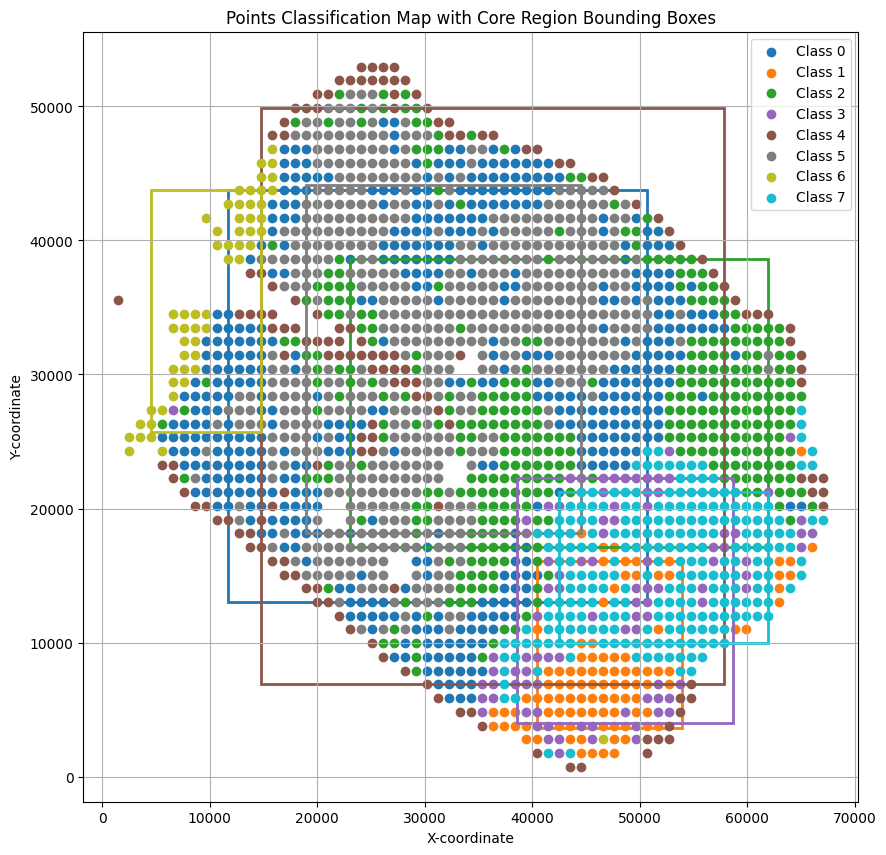

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 示例数据：点的位置和分类标签
labels = np.array(cluster_labels)  # 确保是 NumPy 数组
points = np.array(data['coords'])  # 确保是 NumPy 数组

# 创建颜色映射 (不同的类别不同颜色)
num_classes = len(np.unique(labels))
colors = plt.cm.get_cmap('tab10', num_classes)  # 使用 tab10 颜色映射

# 设置核心区域的百分比范围
lower_percent = 10  # 下边界百分位
upper_percent = 90  # 上边界百分位

# 创建可视化地图
plt.figure(figsize=(10, 10))

# 遍历每个类别
for class_id in range(num_classes):
    # 获取当前类别的点
    class_points = points[labels == class_id]
    
    # 排除边缘点，计算核心区域边界
    x_min_core = np.percentile(class_points[:, 0], lower_percent)
    x_max_core = np.percentile(class_points[:, 0], upper_percent)
    y_min_core = np.percentile(class_points[:, 1], lower_percent)
    y_max_core = np.percentile(class_points[:, 1], upper_percent)
    
    # 筛选出核心区域的点
    core_points = class_points[
        (class_points[:, 0] >= x_min_core) & 
        (class_points[:, 0] <= x_max_core) &
        (class_points[:, 1] >= y_min_core) & 
        (class_points[:, 1] <= y_max_core)
    ]
    
    # 绘制点
    plt.scatter(class_points[:, 0], class_points[:, 1], 
                label=f'Class {class_id}', color=colors(class_id))
    
    # 绘制核心区域的红框 (不同类别不同颜色)
    rect = Rectangle((x_min_core, y_min_core), 
                     x_max_core - x_min_core, 
                     y_max_core - y_min_core, 
                     linewidth=2, edgecolor=colors(class_id), facecolor='none')
    plt.gca().add_patch(rect)  # 将矩形添加到图形中

# 添加标题、图例和网格
plt.title('Points Classification Map with Core Region Bounding Boxes')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_3357375/2559305195.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', num_classes)  # 使用 tab10 颜色映射


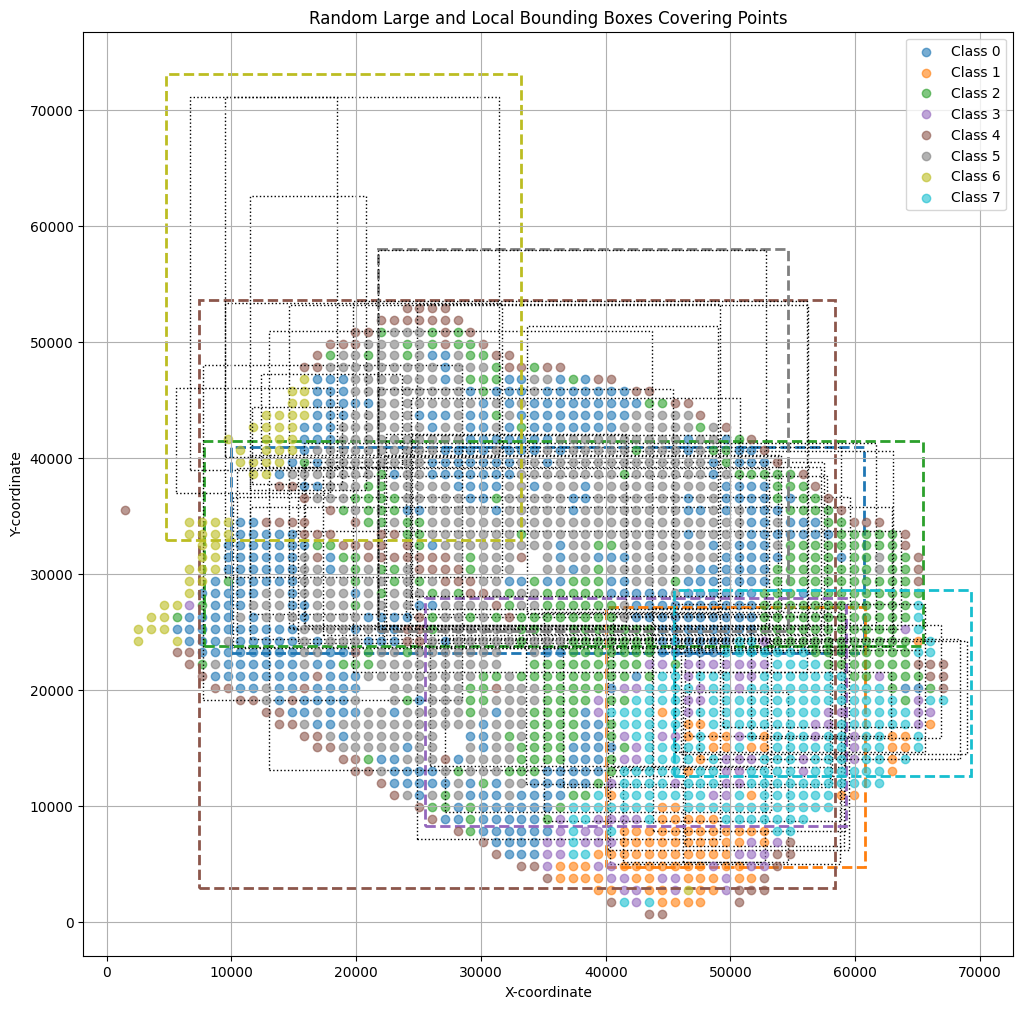

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 示例数据：点的位置和分类标签
labels = np.array(cluster_labels)  # 确保是 NumPy 数组
points = np.array(data['coords'])  # 确保是 NumPy 数组

# 创建颜色映射 (不同的类别不同颜色)
num_classes = len(np.unique(labels))
color_map = plt.cm.get_cmap('tab10', num_classes)  # 使用 tab10 颜色映射

# 目标覆盖率
target_coverage = 0.5  # 目标覆盖率 (40%)
num_local_boxes = 6    # 每个大框内生成的局部小框数量

n_local = 8

# 创建可视化地图
plt.figure(figsize=(12, 12))

# 遍历每个类别
for class_id in range(num_classes):
    # 获取当前类别的点
    class_points = points[labels == class_id]
    
    # 类别点的数量
    num_points = len(class_points)
    target_points = int(num_points * target_coverage)
    
    # 获取点的范围
    x_min, x_max = np.min(class_points[:, 0]), np.max(class_points[:, 0])
    y_min, y_max = np.min(class_points[:, 1]), np.max(class_points[:, 1])
    
    # 随机生成一个大框，调整大小以覆盖目标数量的点
    for _ in range(100):  # 最多尝试 100 次调整方框大小
        # 随机生成左下角点
        x_min_rand = np.random.uniform(x_min, x_max)
        y_min_rand = np.random.uniform(y_min, y_max)
        
        # 随机生成宽度和高度
        width = np.random.uniform(0, x_max - x_min)
        height = np.random.uniform(0, y_max - y_min)
        
        # 方框右上角点
        x_max_rand = x_min_rand + width
        y_max_rand = y_min_rand + height
        
        # 筛选在方框内的点
        box_points = class_points[
            (class_points[:, 0] >= x_min_rand) & 
            (class_points[:, 0] <= x_max_rand) &
            (class_points[:, 1] >= y_min_rand) & 
            (class_points[:, 1] <= y_max_rand)
        ]
        
        # 如果覆盖点接近目标数量，跳出循环
        if len(box_points) >= target_points:
            break
    
    # 绘制点 (所有点)
    plt.scatter(class_points[:, 0], class_points[:, 1], 
                label=f'Class {class_id}', color=color_map(class_id), alpha=0.6)
    
    # 绘制大框
    rect = Rectangle((x_min_rand, y_min_rand), 
                     width, height, 
                     linewidth=2, edgecolor=color_map(class_id), facecolor='none', linestyle='--')
    plt.gca().add_patch(rect)  # 将矩形添加到图形中

    # 在大框内生成局部小框
    for _ in range(num_local_boxes):
        # 局部小框生成时，确保包含足够的点
        while True:
            # 随机生成局部小框左下角点
            x_min_local = np.random.uniform(x_min_rand, x_max_rand)
            y_min_local = np.random.uniform(y_min_rand, y_max_rand)
            
            # 随机生成局部小框宽度和高度
            local_width = np.random.uniform(0, x_max_rand - x_min_local)
            local_height = np.random.uniform(0, y_max_rand - y_min_local)
            
            # 方框右上角点
            x_max_local = x_min_local + local_width
            y_max_local = y_min_local + local_height
            
            # 筛选在局部小框内的点
            local_box_points = class_points[
                (class_points[:, 0] >= x_min_local) & 
                (class_points[:, 0] <= x_max_local) &
                (class_points[:, 1] >= y_min_local) & 
                (class_points[:, 1] <= y_max_local)
            ]
            
            # 如果局部小框内的点数量达到目标，跳出循环
            if len(local_box_points) >= target_points * 0.6:  # 假设每个小框覆盖 20% 的点
                break
        
        # 绘制局部小框
        local_rect = Rectangle((x_min_local, y_min_local), 
                               local_width, local_height, 
                               linewidth=1, edgecolor='black', facecolor='none', linestyle=':')
        plt.gca().add_patch(local_rect)

# 添加标题、图例和网格
plt.title('Random Large and Local Bounding Boxes Covering Points')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3357375/2232092000.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', num_classes)  # 使用 tab10 颜色映射


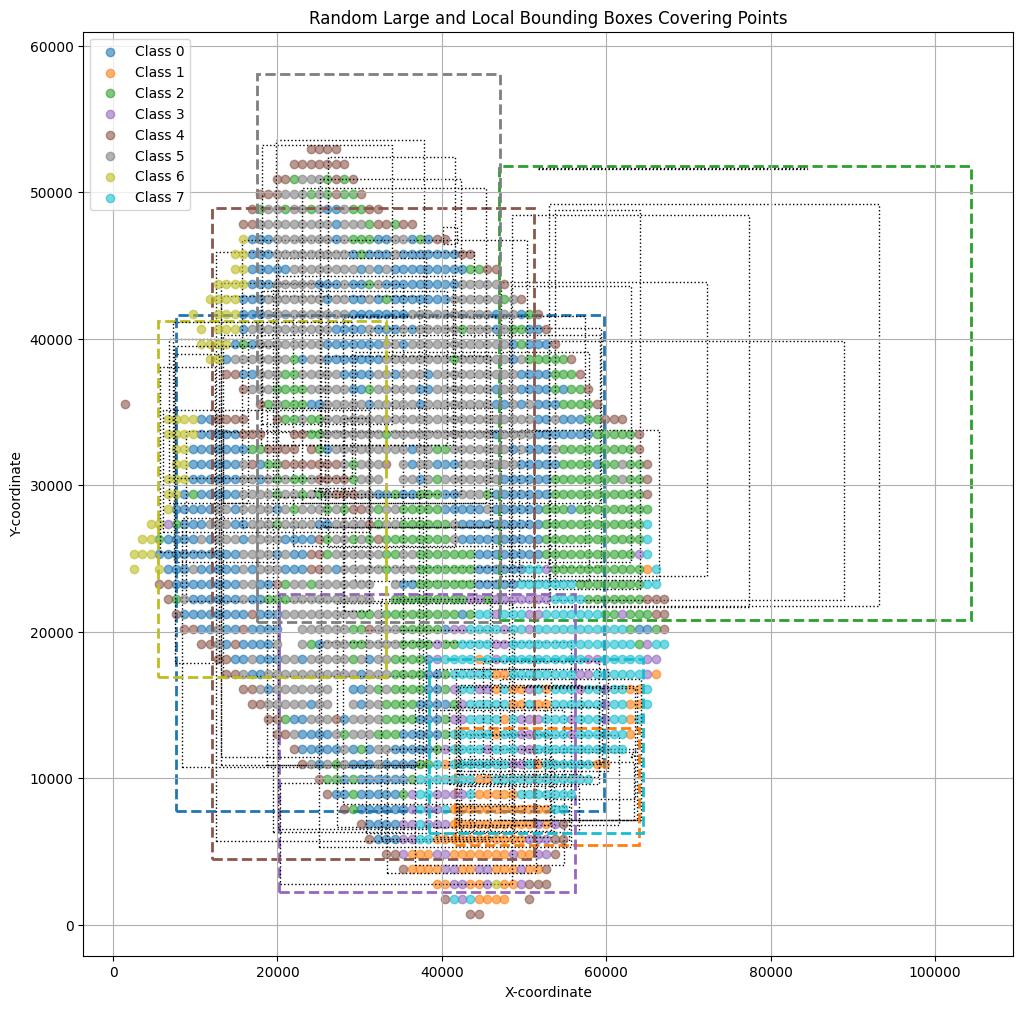

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 示例数据：点的位置和分类标签
labels = np.array(cluster_labels)  # 确保是 NumPy 数组
points = np.array(data['coords'])  # 确保是 NumPy 数组
feature = np.array(data['features'])  # 确保是 NumPy 数组

# 创建颜色映射 (不同的类别不同颜色)
num_classes = len(np.unique(labels))
color_map = plt.cm.get_cmap('tab10', num_classes)  # 使用 tab10 颜色映射

# 目标覆盖率
target_coverage = 0.4  # 目标覆盖率 (50%)
num_local_boxes = 8   # 每个大框内生成的局部小框数量

# 存储大框和小框的坐标位置
global_box = []
local_box = [[] for i in range(1, 9)]  # 用于存储按类分组的小框坐标

global_feature=[]
local_feature=[[] for i in range(1, 9)]  # 用于存储按类分组的小框坐标
# 创建可视化地图
plt.figure(figsize=(12, 12))

# 遍历每个类别

for class_id in range(num_classes):
    # 获取当前类别的点
    class_points = points[labels == class_id]

    # 类别点的数量
    num_points = len(class_points)
    target_points = int(num_points * target_coverage)
    
    # 获取点的范围
    x_min, x_max = np.min(class_points[:, 0]), np.max(class_points[:, 0])
    y_min, y_max = np.min(class_points[:, 1]), np.max(class_points[:, 1])
    
    # 随机生成一个大框，调整大小以覆盖目标数量的点
    for _ in range(100):  # 最多尝试 100 次调整方框大小
        # 随机生成左下角点
        x_min_rand = np.random.uniform(x_min, x_max)
        y_min_rand = np.random.uniform(y_min, y_max)
        
        # 随机生成宽度和高度
        width = np.random.uniform(0, x_max - x_min)
        height = np.random.uniform(0, y_max - y_min)
        
        # 方框右上角点
        x_max_rand = x_min_rand + width
        y_max_rand = y_min_rand + height
        
        # 筛选在方框内的点
        box_points = class_points[
            (class_points[:, 0] >= x_min_rand) & 
            (class_points[:, 0] <= x_max_rand) &
            (class_points[:, 1] >= y_min_rand) & 
            (class_points[:, 1] <= y_max_rand)
        ]
        
        # 如果覆盖点接近目标数量，跳出循环
        if len(box_points) >= target_points:
            break
    
    # 提取大框内的坐标位置
    box_coords = class_points[
        (class_points[:, 0] >= x_min_rand) & 
        (class_points[:, 0] <= x_max_rand) &
        (class_points[:, 1] >= y_min_rand) & 
        (class_points[:, 1] <= y_max_rand)
    ]
    # 拼接大框坐标
    global_box.append(box_coords)
    global_feature.append(feature[[np.where(points == item)[0][0] for item in box_coords]])
    
    # 绘制点 (所有点)
    plt.scatter(class_points[:, 0], class_points[:, 1], 
                label=f'Class {class_id}', color=color_map(class_id), alpha=0.6)
    
    # 绘制大框
    rect = Rectangle((x_min_rand, y_min_rand), 
                     width, height, 
                     linewidth=2, edgecolor=color_map(class_id), facecolor='none', linestyle='--')
    plt.gca().add_patch(rect)  # 将矩形添加到图形中

    # 在大框内生成局部小框
    for index in range(num_local_boxes):
        # 局部小框生成时，确保包含足够的点
        for _ in range(100):
            # 随机生成局部小框左下角点
            x_min_local = np.random.uniform(x_min_rand, x_max_rand)
            y_min_local = np.random.uniform(y_min_rand, y_max_rand)
            
            # 随机生成局部小框宽度和高度
            local_width = np.random.uniform(0, x_max_rand - x_min_local)
            local_height = np.random.uniform(0, y_max_rand - y_min_local)
            
            # 方框右上角点
            x_max_local = x_min_local + local_width
            y_max_local = y_min_local + local_height
            
            # 筛选在局部小框内的点
            local_box_points = class_points[
                (class_points[:, 0] >= x_min_local) & 
                (class_points[:, 0] <= x_max_local) &
                (class_points[:, 1] >= y_min_local) & 
                (class_points[:, 1] <= y_max_local)
            ]
            
            # 如果局部小框内的点数量达到目标，跳出循环
            if len(local_box_points) >= target_points * 0.6:  # 假设每个小框覆盖 60% 的点
                break
        
        # 提取小框内的坐标位置
        local_box_coords = class_points[
            (class_points[:, 0] >= x_min_local) & 
            (class_points[:, 0] <= x_max_local) &
            (class_points[:, 1] >= y_min_local) & 
            (class_points[:, 1] <= y_max_local)
        ]
        
        # 按类将小框坐标分组

        local_box[index].append(local_box_coords)
        local_feature[index].append(feature[[np.where(points == item)[0][0] for item in local_box_coords]])

        # 绘制局部小框
        local_rect = Rectangle((x_min_local, y_min_local), 
                               local_width, local_height, 
                               linewidth=1, edgecolor='black', facecolor='none', linestyle=':')
        plt.gca().add_patch(local_rect)

global_box=np.concatenate(global_box, axis=0)
local_box=[np.concatenate(local_box[i], axis=0) for i in range(len(local_box))]
global_feature=np.concatenate(global_feature, axis=0)
local_feature=[np.concatenate(local_feature[i], axis=0) for i in range(len(local_feature))]

plt.title('Random Large and Local Bounding Boxes Covering Points')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
a=[3,4,6,7]
b=[ele for ele in a if ele not in b]

In [22]:
data=torch.empty(0, 2)
data.shape

torch.Size([0, 2])

In [8]:
import torch
import numpy as np

class BoundingBoxTransform:
    def __init__(self, target_coverage=0.4, num_local_boxes=8):
        self.target_coverage = target_coverage  # Target coverage for points in global box
        self.num_local_boxes = num_local_boxes  # Number of local boxes within the global box
    
    def __call__(self, data):
        """
        Apply bounding box transformation to the input data.
        
        Args:
            data (dict): A dictionary containing the following keys:
                - 'coords' (Tensor): Coordinates of the points (N x 2 tensor)
                - 'labels' (Tensor): Cluster labels of the points (N tensor)
                - 'features' (Tensor): Features corresponding to each point (N x F tensor)
        
        Returns:
            Tuple: 
                - global_box (Tensor): Coordinates of points inside the global boxes
                - local_box (list): List of tensors containing points inside local boxes (per class)
                - global_feature (Tensor): Features of points inside the global boxes
                - local_feature (list): List of tensors containing features inside local boxes (per class)
        """
        labels = data['labels']
        points = data['coords']
        features = data['features']

        # Ensure labels, points, and features are PyTorch tensors
        labels = torch.tensor(labels)
        points = torch.tensor(points)
        features = torch.tensor(features)

        # Initialize containers for global and local boxes and features
        global_box = []
        local_box = [[] for _ in range(self.num_local_boxes)]
        global_feature = []
        local_feature = [[] for _ in range(self.num_local_boxes)]
        
        # Number of unique classes
        num_classes = len(torch.unique(labels))

        # Process each class
        for class_id in range(num_classes):
            # Get the points belonging to the current class
            class_points = points[labels == class_id]
            class_features = features[labels == class_id]
            num_points = class_points.size(0)

            # Target number of points for the global box
            target_points = int(num_points * self.target_coverage)

            # Get the bounds of the points
            x_min, x_max = class_points[:, 0].min(), class_points[:, 0].max()
            y_min, y_max = class_points[:, 1].min(), class_points[:, 1].max()

            # Generate the global bounding box
            for _ in range(100):  # Max attempts for generating a box
                x_min_rand = torch.FloatTensor(1).uniform_(x_min, x_max).item()
                y_min_rand = torch.FloatTensor(1).uniform_(y_min, y_max).item()
                width = torch.FloatTensor(1).uniform_(0, x_max - x_min).item()
                height = torch.FloatTensor(1).uniform_(0, y_max - y_min).item()

                x_max_rand = x_min_rand + width
                y_max_rand = y_min_rand + height

                # Filter points within the global bounding box
                box_points_mask = (
                    (class_points[:, 0] >= x_min_rand) &
                    (class_points[:, 0] <= x_max_rand) &
                    (class_points[:, 1] >= y_min_rand) &
                    (class_points[:, 1] <= y_max_rand)
                )
                box_points = class_points[box_points_mask]
                box_features = class_features[box_points_mask]

                # Check if we have enough points in the box
                if box_points.size(0) >= target_points:
                    break

            # Save the global box coordinates and features
            global_box.append(box_points)
            global_feature.append(box_features)

            # Generate local bounding boxes within the global box
            for index in range(self.num_local_boxes):
                for _ in range(100):  # Max attempts for generating a local box
                    x_min_local = torch.FloatTensor(1).uniform_(x_min_rand, x_max_rand).item()
                    y_min_local = torch.FloatTensor(1).uniform_(y_min_rand, y_max_rand).item()
                    local_width = torch.FloatTensor(1).uniform_(0, x_max_rand - x_min_local).item()
                    local_height = torch.FloatTensor(1).uniform_(0, y_max_rand - y_min_local).item()

                    x_max_local = x_min_local + local_width
                    y_max_local = y_min_local + local_height

                    # Filter points within the local bounding box
                    local_box_points_mask = (
                        (class_points[:, 0] >= x_min_local) &
                        (class_points[:, 0] <= x_max_local) &
                        (class_points[:, 1] >= y_min_local) &
                        (class_points[:, 1] <= y_max_local)
                    )
                    local_box_points = class_points[local_box_points_mask]
                    local_box_features = class_features[local_box_points_mask]

                    # Check if we have enough points in the local box
                    if local_box_points.size(0) >= target_points * 0.6:  # 60% coverage
                        break

                # Save the local box coordinates and features
                local_box[index].append(local_box_points)
                local_feature[index].append(local_box_features)

        # Convert lists to tensors
        global_box = torch.cat(global_box, dim=0)
        local_box = [torch.cat(local_box[i], dim=0) for i in range(len(local_box))]
        global_feature = torch.cat(global_feature, dim=0)
        local_feature = [torch.cat(local_feature[i], dim=0) for i in range(len(local_feature))]

        return global_box, local_box, global_feature, local_feature


In [9]:
# Example data (replace with your actual data)
data = {
    'coords':data['coords'],  
    'labels': cluster_labels,
    'features': data['features']
}

# Create the transform
bbox_transform = BoundingBoxTransform(target_coverage=0.4, num_local_boxes=8)

# Apply the transform
global_box, local_box, global_feature, local_feature = bbox_transform(data)


In [10]:
print(global_box.size())
print(global_feature.size())
for i in range(len(local_box)):
    print(local_box[i].size())

torch.Size([1043, 2])
torch.Size([1043, 384])
torch.Size([417, 2])
torch.Size([581, 2])
torch.Size([620, 2])
torch.Size([414, 2])
torch.Size([412, 2])
torch.Size([507, 2])
torch.Size([264, 2])
torch.Size([518, 2])


In [11]:
import torch
torch.empty(0, 2)

tensor([], size=(0, 2))

In [55]:
import torch
from torch.utils.data import Dataset, DataLoader

def pad_tensors(imgs, coords):
    max_len = max([t.size(0) for t in imgs])  # get the maximum length
    padded_tensors = []
    padded_coords = []
    masks = []
    for i in range(len(imgs)):
        tensor = imgs[i]
        coord = coords[i]
        N_i = tensor.size(0)
        padded_tensor = torch.zeros(max_len, tensor.size(1))
        padded_coord = torch.zeros(max_len, 2)
        mask = torch.zeros(max_len)
        padded_tensor[:N_i] = tensor
        padded_coord[:N_i] = coord
        mask[:N_i] = 1
        padded_tensors.append(padded_tensor)
        padded_coords.append(padded_coord)
        masks.append(mask)
    return torch.stack(padded_tensors), torch.stack(padded_coords), torch.stack(masks).bool()

def pad_local_tensors(local_list):
    """
    Pad a list of local tensors to the same dimension within a sample.
    :param local_list: list of tensors, each tensor shape: [L, D]
    :return: padded_tensor: [num_views, max_L, D], mask: [num_views, max_L]
    """
    max_views = len(local_list)
    max_len = max([t.size(0) for t in local_list])
    feature_dim = local_list[0].size(1)

    padded_local = torch.zeros(max_views, max_len, feature_dim)
    masks = torch.zeros(max_views, max_len)

    for i, local_tensor in enumerate(local_list):
        L = local_tensor.size(0)
        padded_local[i, :L] = local_tensor
        masks[i, :L] = 1

    return padded_local, masks.bool()

def collate_fn(batch):
    """
    Custom collate_fn to pad global and local features/boxes.
    :param batch: list of samples, each sample is a dict:
                  {
                    'global_boxes': Tensor[L_g, 2],
                    'global_features': Tensor[L_g, D_g],
                    'local_boxes': [Tensor[L_l1, 2], Tensor[L_l2, 2], ...],
                    'local_features': [Tensor[L_l1, D_l], Tensor[L_l2, D_l], ...]
                  }
    :return: 
        - padded_global_boxes: Tensor[B, max_Lg, 2]
        - padded_global_features: Tensor[B, max_Lg, D_g]
        - global_masks: Tensor[B, max_Lg]
        - padded_local_boxes: Tensor[B, num_views, max_Ll, 2]
        - padded_local_features: Tensor[B, num_views, max_Ll, D_l]
        - local_masks: Tensor[B, num_views, max_Ll]
    """
    global_boxes_list = []
    global_features_list = []
    local_boxes_list = []
    local_features_list = []

    for sample in batch:
        # Global padding
        global_boxes_list.append(sample['global_boxes'])
        global_features_list.append(sample['global_features'])

        # Local padding within a sample
        local_boxes_padded, _ = pad_local_tensors(sample['local_boxes'])
        local_features_padded, local_masks = pad_local_tensors(sample['local_features'])

        local_boxes_list.append(local_boxes_padded)
        local_features_list.append(local_features_padded)

    # Global padding across the batch
    padded_global_features, padded_global_boxes, global_masks = pad_tensors(global_features_list, global_boxes_list)

    # Local padding across the batch
    max_num_views = max([t.size(0) for t in local_boxes_list])
    max_len_local = max([t.size(1) for t in local_boxes_list])
    local_feature_dim = local_features_list[0].size(2)
    local_box_dim = local_boxes_list[0].size(2)

    padded_local_boxes = torch.zeros(len(batch), max_num_views, max_len_local, local_box_dim)
    padded_local_features = torch.zeros(len(batch), max_num_views, max_len_local, local_feature_dim)
    local_masks = torch.zeros(len(batch), max_num_views, max_len_local)

    for i in range(len(batch)):
        num_views = local_boxes_list[i].size(0)
        len_local = local_boxes_list[i].size(1)
        padded_local_boxes[i, :num_views, :len_local] = local_boxes_list[i]
        padded_local_features[i, :num_views, :len_local] = local_features_list[i]
        local_masks[i, :num_views, :len_local] = 1

    return {
        'padded_global_boxes': padded_global_boxes,
        'padded_global_features': padded_global_features,
        'global_masks': global_masks,
        'padded_local_boxes': padded_local_boxes,
        'padded_local_features': padded_local_features,
        'local_masks': local_masks.bool()
    }

# Test Dataset class
class TestDataset(Dataset):
    def __init__(self, num_samples=4):
        self.num_samples = num_samples

    def __getitem__(self, idx):
        # Generate random lengths for global and local features
        global_len = torch.randint(5, 10, (1,)).item()
        local_views = torch.randint(2, 5, (1,)).item()
        local_lens = [torch.randint(3, 8, (1,)).item() for _ in range(local_views)]

        # Global boxes and features
        global_boxes = torch.randn(global_len, 2)
        global_features = torch.randn(global_len, 8)

        # Local boxes and features
        local_boxes = [torch.randn(l, 2) for l in local_lens]
        local_features = [torch.randn(l, 6) for l in local_lens]

        return {
            'global_boxes': global_boxes,
            'global_features': global_features,
            'local_boxes': local_boxes,
            'local_features': local_features
        }

    def __len__(self):
        return self.num_samples

# Create dataset and dataloader
dataset = TestDataset(num_samples=4)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

# Test the dataloader
for batch in dataloader:
    print("Padded Global Boxes:", batch['padded_global_boxes'].shape)
    print("Padded Global Features:", batch['padded_global_features'].shape)
    print("Global Masks:", batch['global_masks'].shape)
    print("Padded Local Boxes:", batch['padded_local_boxes'].shape)
    print("Padded Local Features:", batch['padded_local_features'].shape)
    print("Local Masks:", batch['local_masks'].shape)
    break


Padded Global Boxes: torch.Size([2, 7, 2])
Padded Global Features: torch.Size([2, 7, 8])
Global Masks: torch.Size([2, 7])
Padded Local Boxes: torch.Size([2, 2, 6, 2])
Padded Local Features: torch.Size([2, 2, 6, 6])
Local Masks: torch.Size([2, 2, 6])


In [33]:
global_len = torch.randint(5, 10, (1,)).item()
global_len

8

In [43]:
global_len = torch.randint(5, 10, (1,)).item()
local_views = torch.randint(2, 5, (1,)).item()
local_lens = [torch.randint(3, 8, (1,)).item() for _ in range(local_views)]

# Global boxes and features
global_boxes = torch.randn(global_len, 2)
global_features = torch.randn(global_len, 8)

# Local boxes and features
local_boxes = [torch.randn(l, 2) for l in local_lens]
local_features = [torch.randn(l, 6) for l in local_lens]


In [44]:
local_boxes[0].shape
print(len(local_boxes))

4
